<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 6: Spatial clustering</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bG/lab_G.html

## Clustering, spatial clustering, and geodemographics

本节涉及空间观测的统计聚类。许多问题和主题都是复杂的现象，涉及多个维度，难以归纳为一个单一的变量。在统计学术语中，我们把这一类问题称为*多变量*，而不是在分析中只考虑单一变量的*单变量*情况。聚类处理这类问题的方法是降低其维度--分析师需要查看的相关变量的数量，并将其转换为更直观的类集，即使是非技术性的受众也可以查看并理解。出于这个原因，它被广泛用于决策或营销等应用场合。此外，由于这些方法不需要很多关于数据结构的初步假设，它是一种常用的探索性工具，因为它可以迅速提供关于数据集的形状、形式和内容的线索。

统计聚类的基本思想是通过创建相对较少的类别来总结几个变量中包含的信息。然后，数据集中的每个观测值都被分配到一个，而且只有一个类别，这取决于它在分类中最初考虑的变量的值。如果做得正确，这种做法可以减少多维问题的复杂性，同时保留原始数据集中包含的所有有意义的信息。这是因为，一旦分类，分析师只需要看每一个观察结果属于哪个类别，而不是考虑与每个变量相关的多个值，并试图找出如何将它们连贯起来。当对代表地区的观测值进行聚类时，这种技术通常被称为地理人口分析。

尽管存在许多技术来对数据集中的观测值进行统计分组，但所有这些技术都基于这样一个前提，即使用一组属性来定义观测值的类或类别，这些类或类别*在每个组内是相似的，但*在组之间是不同的。如何定义组内的相似性和组间的不相似性，以及如何操作分类算法是使技术不同的原因，也是使每个技术特别适合于特定问题或数据类型的原因。作为一个例子，我们将只涉足其中的一种方法--K-means，它可能是最常用的统计聚类技术。

在分析空间数据的情况下，有一个方法子集对地理数据科学的许多常见情况特别感兴趣。这些是所谓的*区域化*技术。区域化方法也可以有很多形式和面貌，但就其核心而言，它们都涉及观察值的统计聚类，并有一个额外的约束条件，即观察值需要是地理上的邻居，才能归入同一类别。正因为如此，我们将对每个观测值使用*区域*一词，对每个类别使用*区域*一词，因此区域化，即从较小的区域中构建区域。

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
import esda
from splot.libpysal import plot_spatial_weights

d:\work\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

我们这次要使用的数据集是从在线网站[AirBnb](http://www.airbnb.com)中提取的。AirBnb是一家公司，为那些在访问一个城市时寻找酒店替代品的人，以及那些想出租（部分）自己的房子以赚取额外收入的当地人提供了一个会面点。该网站有一个不断更新的清单，列出了某一城市的所有可用房产，客户可以通过该清单进行查询和预订。此外，该网站还提供了一个反馈机制，主人和客人两端都可以对他们的经验进行评价。AirBnb汇总了客人对他们所住房源的评分，为每处房源提供了额外的信息，如整体清洁度评分或主人与客人沟通的好坏指数。

原始数据是在物业层面和整个伦敦提供的。然而，由于这本笔记的目的，物业的总数非常大，他们已经在中间超级输出区（MSOA），一个由国家统计局创建的地理单位进行了汇总。虽然原始资料包含了大伦敦地区的信息，但绝大多数房产都位于内伦敦，所以我们将使用的数据也仅限于此。即使在这种情况下，也不是每个多边形都有至少一个房产。为了避免缺失值的情况，最终的数据集只包含那些至少有一个房产的MSOAs，所以可以有与之相关的平均评级。

我们在这本笔记中的目标是根据AirBnb地点的评级，对内伦敦的地区（MSOA）进行分类。这将使我们能够为伦敦的AirBnb地理学创建一个类型学，并且在AirBnb地点能够说明它们所在地区的程度上，这个分类将帮助我们更好地理解伦敦的住宅地理学。关于我们可以从像这样的分析中得出的结论，有一个一般性的警告，这来自于AirBnb数据的性质。一方面，这个数据集是数据革命使分析成为可能的一个很好的例子，因为仅仅在几年前，我们很难获得类似于这样的大型房产评级调查。另一方面，重要的是要牢记这些数据的偏见，因此，在将调查结果推广到一般人群方面存在局限性。无论如何，这个数据集是学习空间观察统计聚类的一个很好的例子，无论是在地理人口方面还是在区域化方面。

让我们从阅读MSOA的主表开始。

In [2]:
# Read the file in
abb = gpd.read_file(
    "files/london_abb.gpkg"
)

In [3]:
# Inspect the structure of the table
abb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   MSOA_CODE                    353 non-null    object  
 1   accommodates                 353 non-null    float64 
 2   bathrooms                    353 non-null    float64 
 3   bedrooms                     353 non-null    float64 
 4   beds                         353 non-null    float64 
 5   number_of_reviews            353 non-null    float64 
 6   reviews_per_month            353 non-null    float64 
 7   review_scores_rating         353 non-null    float64 
 8   review_scores_accuracy       353 non-null    float64 
 9   review_scores_cleanliness    353 non-null    float64 
 10  review_scores_checkin        353 non-null    float64 
 11  review_scores_communication  353 non-null    float64 
 12  review_scores_location       353 non-null    float64 
 1

在我们开始探索数据之前，有一个额外的步骤将在接下来的工作中派上用场。表中并非每个变量都是我们要进行聚类的属性。特别是，我们对评论评级感兴趣，所以我们将只考虑这些。因此，让我们先手动写出它们，这样它们就更容易进行子集。

In [4]:
ratings = [
    'review_scores_rating', 
    'review_scores_accuracy', 
    'review_scores_cleanliness', 
    'review_scores_checkin', 
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

在本节的后面，我们还将使用AirBnb所说的邻里。让我们把它们装进去，这样当我们需要它们的时候，它们就准备好了。


In [5]:
boroughs = gpd.read_file(
    "files/london_inner_boroughs.geojson"
)
boroughs

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Lambeth,E09000022,2724.940,43.927,T,None,None,"POLYGON ((-0.12846 51.48505, -0.12843 51.48506..."
1,Southwark,E09000028,2991.340,105.139,T,None,None,"POLYGON ((-0.10892 51.50844, -0.10889 51.50845..."
2,Lewisham,E09000023,3531.706,16.795,T,None,None,"POLYGON ((-0.03241 51.49306, -0.03240 51.49303..."
3,Greenwich,E09000011,5044.190,310.785,F,None,None,"MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51..."
4,Wandsworth,E09000032,3522.022,95.600,T,None,None,"POLYGON ((-0.22343 51.47152, -0.22327 51.47146..."
5,Hammersmith and Fulham,E09000013,1715.409,75.648,T,None,None,"POLYGON ((-0.24456 51.48870, -0.24460 51.48879..."
6,Kensington and Chelsea,E09000020,1238.379,25.994,T,None,None,"POLYGON ((-0.18388 51.47742, -0.18403 51.47753..."
7,Westminster,E09000033,2203.005,54.308,T,None,None,"POLYGON ((-0.15000 51.48548, -0.15009 51.48590..."
8,Camden,E09000007,2178.932,0.000,T,None,None,"POLYGON ((-0.14242 51.56912, -0.14250 51.56901..."
9,Tower Hamlets,E09000030,2157.501,179.707,T,None,None,"POLYGON ((-0.07938 51.50784, -0.07935 51.50791..."


请注意，与以前的数据集相比，这个数据集是以一种新的格式提供的，即`.geojson`。GeoJSON文件是一个纯文本文件（你可以在任何文本编辑器上打开它，看到它的内容），它遵循JSON格式的结构，广泛用于在网络上交换信息，适应于地理数据，因此前面有`geo`。随着网络地图的兴起，GeoJSON文件得到了广泛的欢迎，并迅速成为小型数据集的事实标准，因为它们可以被人类和许多不同的平台所阅读。正如你在上面看到的，在Python中读取它们与读取shapefile完全一样，比如说。

## Getting to know the data

开始探索AirBnb评级地理的最好方法是将每个评级绘制成不同的地图。这将使我们对我们感兴趣的每个变量有一个单变量的视角。

由于我们有很多列要绘制，我们将创建一个循环，为我们生成每张地图，并将其放在主图的 `子图`上。

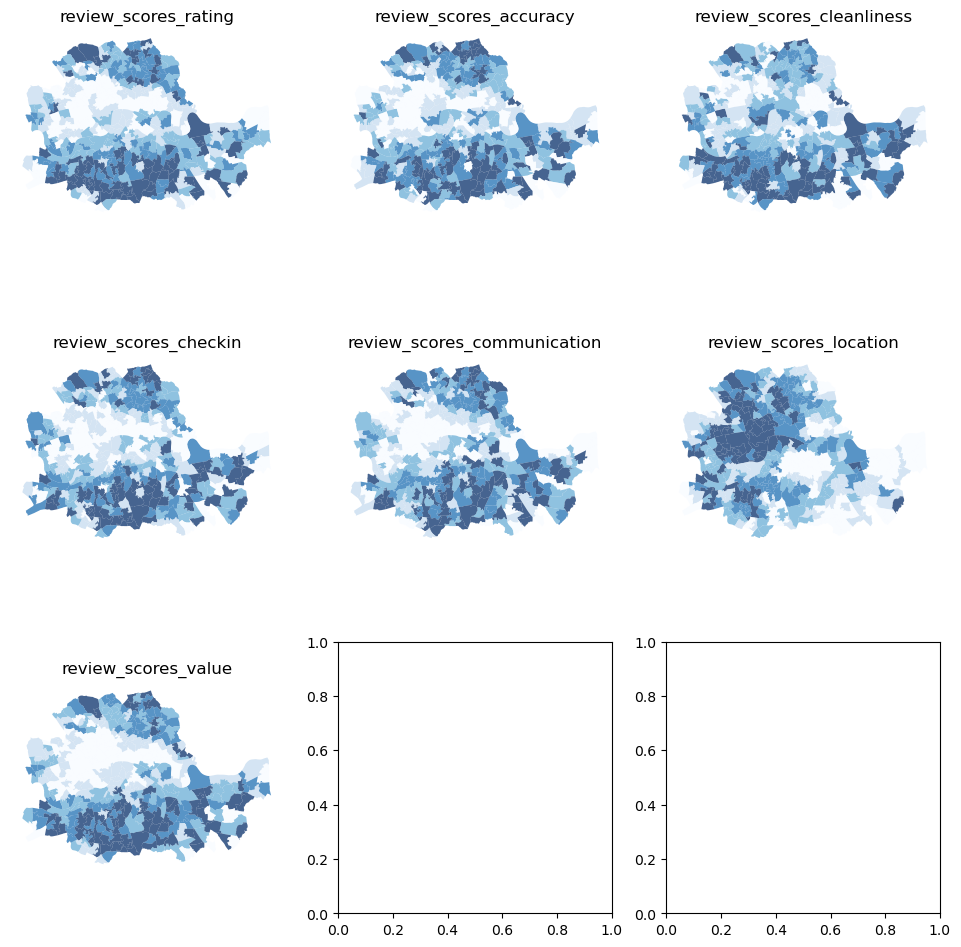

In [6]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(ratings):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(
        column=col, 
        ax=ax, 
        scheme='Quantiles',
        linewidth=0, 
        cmap='Blues', 
        alpha=0.75
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

在我们深入研究地图的实质性解释之前，让我们先走一遍创建上图的过程，这涉及到同一图内的几个子图。

* 首先（L. 2）我们为子图的网格设置我们想要的行和列的数量。
* 产生的对象`axs`不是一个，而是一个网格（或数组）的轴。正因为如此，我们不能直接在`axs`上绘图，而是需要访问每个单独的轴。
* 为了使这一步更容易，我们用`flatten`（L. 4）将网格解包成一个平面列表（数组），用于每个子图的轴。
* 在这一点上，我们设置了一个`for`循环（L. 6），在每个子图中绘制一个地图。
* 在循环中（L. 6-14），我们提取轴（L. 8），在其上绘制choropleth（L. 10），并对地图进行样式设计（L. 11-14）。
* 显示图（L. 16）。

我们可以看到，不同方面的评价在空间上的分布有很大的差异。虽然像总体价值（"review_scores_value"）或沟通（"review_scores_communication"）这样的变量倾向于在周边地区较高，但像位置得分（"review_scores_location"）这样的变量则主要集中在城市中心。

让我们从统计学上检查一下我们在用眼睛看图时的怀疑--所有评级变量都有高水平的显著聚类。

In [7]:
w = weights.Queen.from_dataframe(abb)
# Calculate Moran's I for each variable
mi_results = [esda.Moran(abb[variable], w) for variable in ratings]
# Structure results as a list of tuples
mi_results = [(variable, res.I, res.p_sim) for variable,res in zip(ratings, mi_results)]
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Variable', "Moran's I", 'P-value']
).set_index('Variable')
table

,Moran's I,P-value
Variable,,
review_scores_rating,0.448577,0.001
review_scores_accuracy,0.326009,0.001
review_scores_cleanliness,0.347948,0.001
review_scores_checkin,0.365247,0.001
review_scores_communication,0.357104,0.001
review_scores_location,0.591462,0.001
review_scores_value,0.486141,0.001


### A multivariate look

尽管我们只有七个变量，但很难在 "精神上叠加 "所有的变量，以得出对伦敦每个部分的性质的总体评估。对于成对的双变量相关性，一个有用的工具是相关矩阵图，可在`seaborn`中使用。

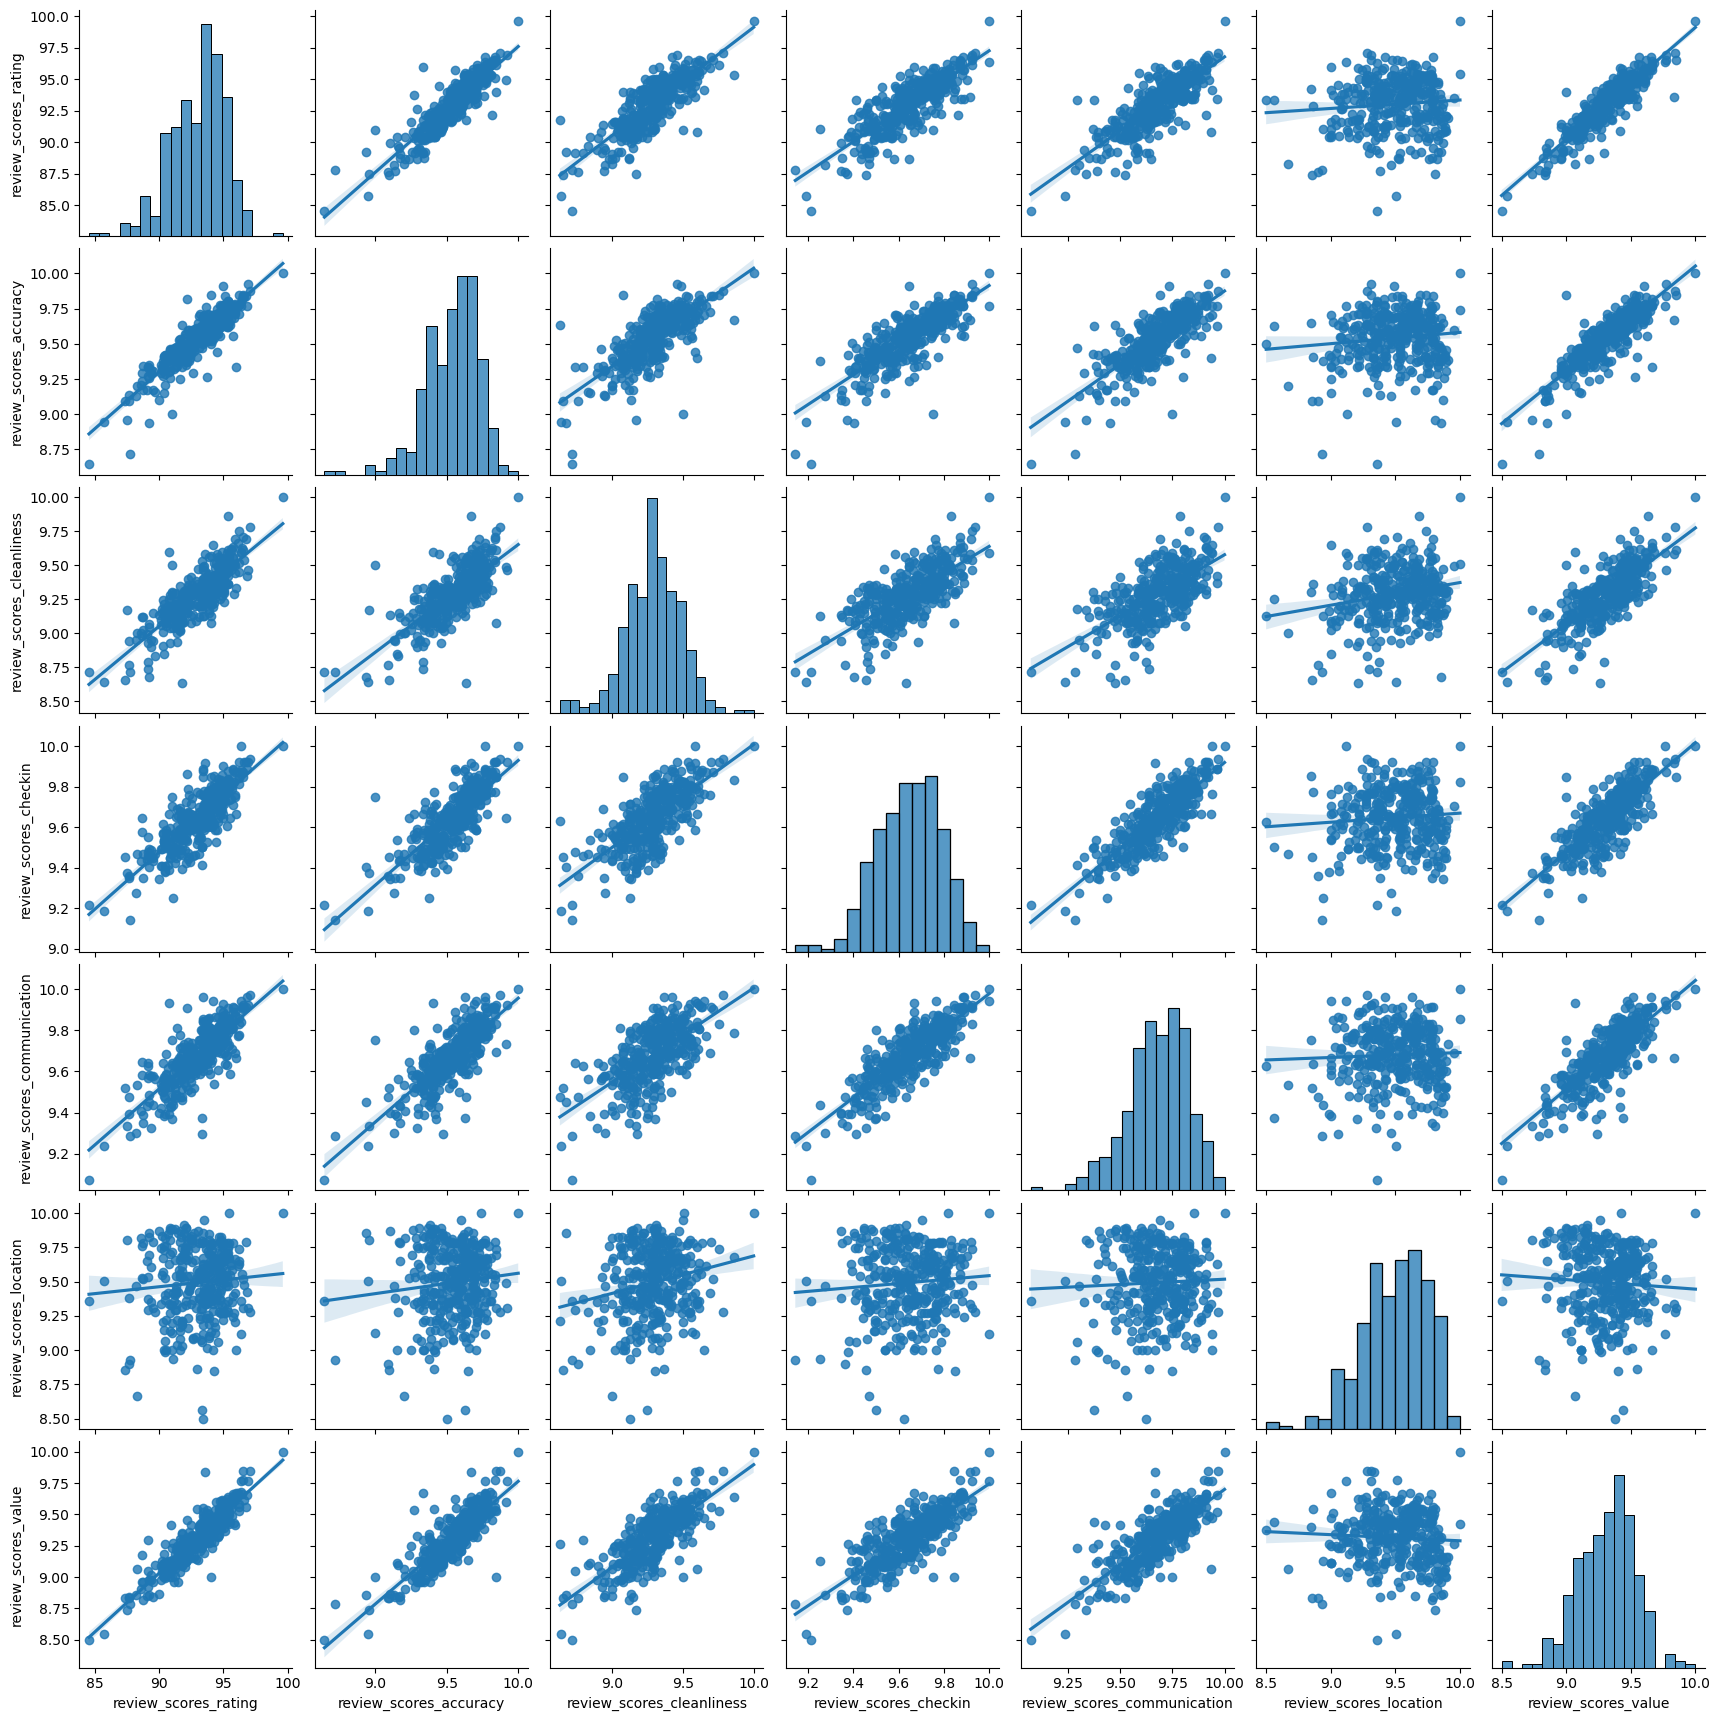

In [8]:
_ = sns.pairplot(abb[ratings], kind='reg', diag_kind='hist')

这对考虑单变量和双变量的问题是有帮助的，如： *总体（"评级"）和位置得分之间有什么关系？*总体（"评级"）和位置得分之间有什么关系？*（正面） *总体评级与位置或清洁度的相关性更大？*（清洁度） 然而，有时，这还不够，我们对真正的多变量的更复杂的问题感兴趣，在这些情况下，上图不能帮助我们。例如，要回答这样的问题并不直截了当。*伦敦南部的主要特点是什么？*哪些地区与城市的核心区相似？*伦敦的东部和西部在你能找到的AirBnb房产种类方面是否相似？*对于这类多维问题--同时涉及多个变量--我们需要一种真正的多维方法，如统计聚类。

## 使用K-means对内伦敦的AirBnb地理人口进行分类

地理人口学分析涉及到将构成地理地图的区域划分为彼此相似但彼此不同的观察组或类别。分类是通过统计聚类算法进行的，该算法将一组属性作为输入，并返回每个观测值所属的组（术语中的 "标签"）。根据所采用的特定算法，还需要输入其他参数，如所需的聚类数量或更高级的调整参数（如带宽、半径等），作为输入。对于我们对内伦敦的AirBnb评级的地理人口分类，我们将使用最流行的聚类算法之一。K-means。这种技术只需要输入观察属性和我们希望它将观察结果聚类的最终组数。在我们的案例中，我们将使用五个开始，因为这将使我们能够更仔细地观察每一个组。

尽管基础算法并不简单，但由于`scikit-learn`的存在，在Python中运行K-means是很容易的。与库中大量可用的算法类似，它的计算只需两行代码。首先，我们需要在 "KMeans "方法（属于`scikit-learn`的`cluster`子模块）中指定参数。注意，在这一点上，我们甚至不需要传递数据。

In [9]:
kmeans5 = cluster.KMeans(n_clusters=5, random_state=12345)

这就建立了一个对象，持有运行算法所需的所有参数。在我们的例子中，我们只传递了集群的数量（`n_clusters`）和随机状态，这个数字可以确保K-Means的每一次运行都是相同的，因此可以重复进行。

为了在属性上实际运行算法，我们需要调用`kmeans5`中的`fit`方法。

In [10]:
# Run the clustering algorithm
k5cls = kmeans5.fit(abb[ratings])

d:\work\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


我们刚刚创建的 `k5cls` 对象包含几个对分析有用的组件。现在，我们将使用标签，它代表我们将数据分组的不同类别。记住，在Python中，生命从零开始，所以分组标签从零到四。标签可以被提取出来，如下所示。

In [11]:
k5cls.labels_

array([0, 2, 2, 2, 1, 1, 2, 3, 0, 3, 1, 3, 0, 3, 3, 3, 2, 1, 1, 0, 0, 0,
       4, 4, 4, 4, 4, 0, 0, 4, 0, 0, 3, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1,
       2, 1, 1, 1, 2, 2, 3, 4, 0, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 1, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 3, 3,
       3, 1, 1, 3, 1, 1, 3, 1, 1, 0, 1, 0, 3, 4, 0, 0, 3, 1, 1, 3, 0, 2,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 2, 2, 0,
       3, 0, 3, 3, 0, 1, 1, 3, 1, 3, 2, 1, 4, 3, 3, 0, 0, 4, 0, 0, 3, 3,
       3, 3, 0, 3, 3, 3, 3, 2, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2,
       2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 4, 3, 1, 3, 1, 2, 1,
       2, 1, 1, 1, 2, 1, 1, 2, 2, 3, 2, 0, 2, 2, 2, 2, 4, 1, 3, 2, 1, 2,
       2, 1, 4, 2, 2, 3, 1, 0, 1, 3, 1, 1, 3, 0, 3, 2, 0, 0, 3, 0, 0, 1,
       0, 3, 3, 1, 1, 1, 3, 1, 1, 3, 2, 1, 2, 2, 2, 3, 2, 2, 2, 1, 1, 1,
       1, 3, 3, 0, 1, 3, 0, 4, 2, 0, 3, 4, 0, 4, 2, 0, 3, 0, 4, 0, 3, 0,
       0, 1, 3, 0, 4, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2,

每个数字代表一个不同的类别，所以两个具有相同数字的观察值属于同一个组。标签的返回顺序与输入属性的传递顺序相同，这意味着我们可以将它们作为一个额外的列追加到原始数据表中。

In [12]:
abb['k5cls'] = k5cls.labels_
abb

,MSOA_CODE,accommodates,bathrooms,bedrooms,beds,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,property_count,BOROUGH,GSS_CODE,geometry,k5cls
0,E02000001,3.298701,1.215368,1.201299,1.557484,16.465368,1.231254,90.836858,9.386707,9.280120,9.498489,9.425982,9.697885,9.042296,462,City of London,E09000001,"POLYGON ((-0.08522 51.52033, -0.08522 51.52033...",0
1,E02000166,3.659341,1.467033,1.725275,2.054945,13.252747,0.957015,95.061538,9.676923,9.292308,9.753846,9.800000,9.692308,9.538462,91,Camden,E09000007,"POLYGON ((-0.14929 51.57113, -0.14929 51.57113...",2
2,E02000167,3.720000,1.412000,1.688000,1.992000,19.488000,1.104396,95.438202,9.741573,9.505618,9.820225,9.853933,10.000000,9.420455,125,Camden,E09000007,"POLYGON ((-0.16594 51.56306, -0.16576 51.56284...",2
3,E02000168,4.006993,1.419580,1.804196,2.188811,18.356643,1.009450,94.822430,9.766355,9.551402,9.831776,9.757009,9.803738,9.542056,143,Camden,E09000007,"POLYGON ((-0.14085 51.56181, -0.14091 51.56168...",2
4,E02000169,3.543689,1.577670,1.679612,2.058824,6.048544,0.713662,93.400000,9.600000,9.400000,9.757143,9.600000,9.600000,9.328571,103,Camden,E09000007,"POLYGON ((-0.18604 51.56240, -0.18591 51.56240...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,E02000979,3.806202,1.525194,1.575875,1.933852,24.922481,1.704434,93.009569,9.650718,9.473684,9.535885,9.607656,9.866029,9.133971,258,Westminster,E09000033,"POLYGON ((-0.11895 51.50759, -0.11895 51.50759...",1
349,E02000980,3.610000,1.217500,1.410000,1.875000,21.010000,1.579277,92.060976,9.457317,9.317073,9.603659,9.652439,9.890244,9.158537,200,Westminster,E09000033,"POLYGON ((-0.12279 51.49453, -0.12279 51.49452...",3
350,E02000981,3.478571,1.341071,1.368515,1.985560,33.001786,1.618382,90.866109,9.407950,9.198745,9.595388,9.564854,9.802935,9.046122,560,Westminster,E09000033,"POLYGON ((-0.14126 51.49455, -0.14120 51.49449...",0
351,E02000982,3.280952,1.272727,1.285714,1.745192,15.995238,1.242976,91.753086,9.388889,9.290123,9.462963,9.462963,9.611111,9.092593,210,Westminster,E09000033,"POLYGON ((-0.14126 51.49455, -0.14126 51.49455...",3


### 绘制类别图

为了更好地理解我们刚刚进行的分类，在地图上显示创建的类别是很有用的。为此，我们将使用一个独特的价值轮廓图，它将自动为每个类别分配不同的颜色。

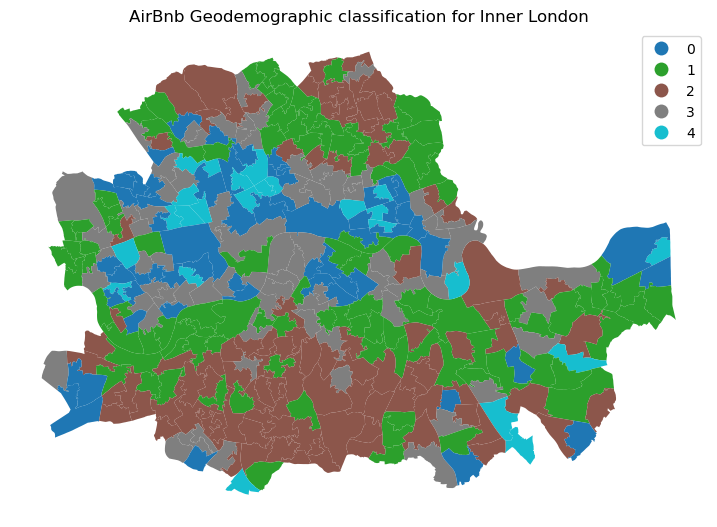

In [13]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(
    column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb Geodemographic classification for Inner London')
# Display the map
plt.show()

上面的地图代表了由K-means算法创建的五个类别的地理分布。一眼就能看出颜色分布的强烈空间结构：零组（蓝色）大多在市中心，几乎不在外围，而第一组（绿色）和第二组（棕色）则主要集中在南部地区。第三组（灰色）是一个中间组，而第四组（绿松石色）则小得多，只包含少数的观察结果。

### 探讨类别的性质

一旦我们对类别在空间上的分布位置和方式有了感觉，从统计学上探索它们也是有用的。这将使我们能够描述它们的特征，使我们了解归入每个类别的观察的种类。作为第一步，让我们找出每个类别中有多少观测值。为了做到这一点，我们将使用前面介绍的`groupby`操作符，结合函数`size`，它返回一个子组中的元素数量。

In [14]:
k5sizes = abb.groupby('k5cls').size()
k5sizes

k5cls
0     56
1    104
2     98
3     72
4     23
dtype: int64

`groupby`操作符使用提供的列（`k5cls`）中的值对表（`DataFrame`）进行分组，并将它们传递给之后提供的函数，在本例中是`size`。实际上，这就是按创建的类别对观察值进行分组，并计算每个观察值包含多少个。为了更直观地表示输出，柱状图是一个很好的选择。

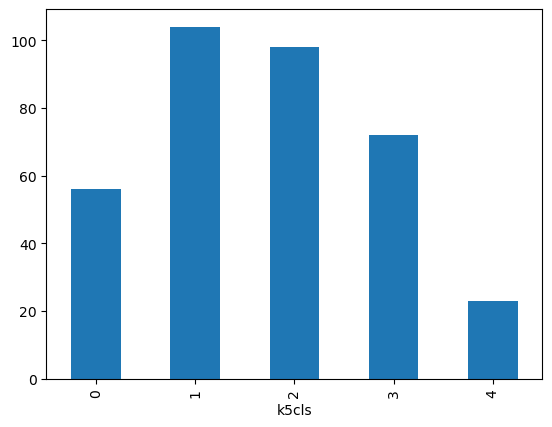

In [15]:
_ = k5sizes.plot.bar()

正如我们从地图上所怀疑的那样，组的大小不一，一、二、三组各超过70个观测值，而四组则低于25个。

为了描述每个类别的性质，我们可以看一下我们首先用来创建它们的每个属性的值。记得我们使用了许多方面（清洁度、主人的沟通等）的平均评分来创建分类，所以我们可以从检查每个方面的平均值开始。为了在Python中做到这一点，我们将依靠`groupby`操作符，我们将把它与函数`mean`结合起来。

In [16]:
# Calculate the mean by group
k5means = abb.groupby('k5cls')[ratings].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
review_scores_rating,90.725593,93.727497,95.330624,92.134328,88.322160
review_scores_accuracy,9.355684,9.605591,9.717272,9.472732,9.149055
review_scores_cleanliness,9.132700,9.328059,9.478406,9.214409,8.907681
review_scores_checkin,9.510472,9.679087,9.785712,9.588242,9.413322
review_scores_communication,9.543217,9.722030,9.804255,9.627248,9.444095
review_scores_location,9.448517,9.443591,9.539375,9.546235,9.454598
review_scores_value,9.090933,9.384535,9.531206,9.220018,8.901364


关于地理统计学的部分到此结束。正如我们所看到的，这种方法的本质是在纯粹的统计基础上对区域进行分组。*每个区域所处的*位置与它从聚类算法中得到的标签无关。在许多情况下，这不仅是允许的，甚至是可取的，因为我们的兴趣是看特定的价值组合是否以任何可识别的方式分布在空间。然而，在其他情况下，我们可能对创建的遵循某些空间约束的观察组感兴趣。为此，我们现在转向了区域化技术。

## 区域化算法

区域化是聚类技术的一个子集，它对分类施加了空间约束。换句话说，区域化算法的结果包含空间上相邻的区域。实际上，这意味着这些技术将区域聚集成较小的一组较大的区域，称为区域。那么，在这种情况下，地区是*嵌套在区域内的。这种现象的现实例子包括州内的县，或者在英国，地方超级输出区（LSOA）与中间超级输出区（MSOA）。这些例子与区域化算法输出的区别在于，前者是根据行政管理原则进行汇总，而后者则遵循一种统计技术，与标准的统计聚类非常相似，根据一组属性将相似的地区组合在一起。只是现在，这种统计聚类在空间上受到限制。

与非空间的情况一样，有许多不同的算法来执行区域化，它们在与衡量（不）相似性的方式、区域化的过程等有关的细节上都有所不同。然而，和上面一样，它们都有一些共同点。特别是，它们都需要一组输入属性*和*二元空间权重矩阵形式的空间表示。根据不同的算法，它们还需要所需数量的输出区域，这些区域被汇总到一起。

为了说明这些概念，我们将在我们一直使用的AirBnb数据上运行一个区域化算法。在这种情况下，我们的目标是根据AirBnb房产的不同平均评级，而不是现有边界线背后的行政原因，重新划定内伦敦各区的边界线。通过这种方式，所产生的区域将代表一组一致的区域，这些区域在收到的评级方面彼此相似。

### 正式定义空间

与ESDA技术一样，区域化方法也需要一个便于统计的正式空间表示。在实践中，这意味着我们将需要为要汇总的地区创建一个空间权重矩阵。

从技术上讲，这与我们之前看到的过程相同，这要归功于`PySAL`。在这种情况下，不同的是，我们不是从shapefile开始，而是从GeoJSON开始。幸运的是，`PySAL`支持 "即时"构建空间权重矩阵，也就是从一个表格开始。这是一个单行本。

In [17]:
w = weights.Queen.from_dataframe(abb)

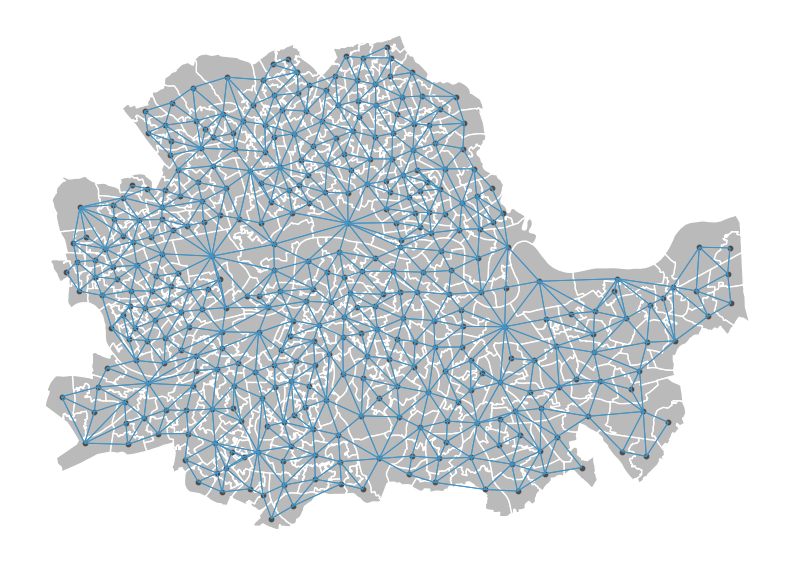

In [18]:
plot_spatial_weights(w, abb.to_crs(epsg=27700)); # Use the British National Grid, 27700

### 从地区创建区域

在这一点上，我们拥有运行区域化算法所需的所有部件。在这个例子中，我们将使用空间约束版的聚类算法。这与上面使用的方法类似（但算法的内部工作原理不同），不同的是，在这种情况下，只有当观测值是空间邻居时，才能被标记为同一组，如我们的空间权重矩阵`w`所定义。与该算法互动的方式与上述非常相似。我们首先设置参数。

In [19]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=13, connectivity=w.sparse)
sagg13

AgglomerativeClustering(connectivity=<353x353 sparse matrix of type '<class 'numpy.float64'>'
	with 1978 stored elements in Compressed Sparse Row format>,
                        n_clusters=13)

我们可以通过调用`fit`来运行算法。

In [20]:
# Run the clustering algorithm
sagg13cls = sagg13.fit(abb[ratings])

然后我们把标签附加到表格上。

In [21]:
abb['sagg13cls'] = sagg13cls.labels_

### 绘制所产生的区域图

在这一点上，`sagg13cls`列与`k5cls`没有什么不同：一个分类变量，可以被映射到一个唯一值的正方形。事实上，下面的代码片段与之前完全相同，只是替换了要映射的变量名称和标题。

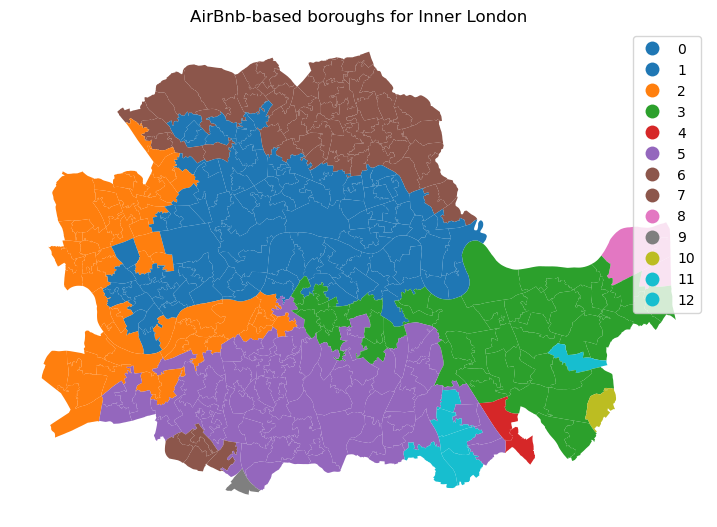

In [22]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(
    column='sagg13cls', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London')
# Display the map
plt.show()

### 比较有机划界和行政划界

上面的地图让人对算法的边界划定有一个非常清晰的印象。然而，它仍然是基于小区域的多边形。为了 "正确地 "创建新的区，我们需要将每个类别中的所有多边形溶解为一个单一的区。这是一个标准的GIS操作，由 "geopandas "支持，可以很容易地用我们之前使用的 "groupby"操作符进行操作。唯一复杂的是，我们需要把它包装成一个单独的函数，以便能够把它传递给`groupby`。我们首先定义函数`dissolve`。

In [23]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

然后可以得到AirBnb区的边界，如下所示。

In [24]:
# Dissolve the polygons based on `sagg13cls`
abb_boroughs = gpd.GeoSeries(
    abb.groupby(abb['sagg13cls']).apply(dissolve),
    crs=abb.crs
)

这里我们可以 plot:

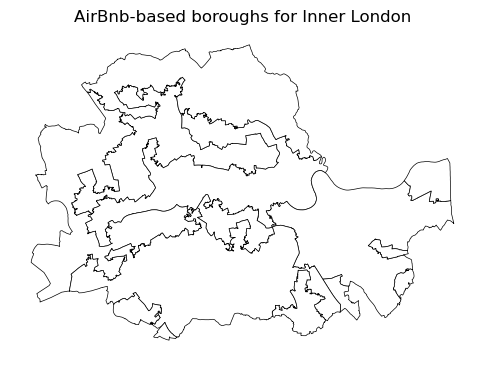

In [25]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
abb_boroughs.plot(
    ax=ax, 
    linewidth=0.5,
    facecolor='white', 
    edgecolor='k'
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London');

上面的划分提供了对AirBnb房产地理的看法。根据我们的区域化算法，每个划定的区域所包含的房屋都比邻近地区的房屋更相似。现在，让我们把我们从数据中有机地得出的这个地理区域与官方的行政边界集进行比较。例如，与伦敦各区。

记得我们在笔记本的开头读过这些。

In [26]:
boroughs

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Lambeth,E09000022,2724.940,43.927,T,None,None,"POLYGON ((-0.12846 51.48505, -0.12843 51.48506..."
1,Southwark,E09000028,2991.340,105.139,T,None,None,"POLYGON ((-0.10892 51.50844, -0.10889 51.50845..."
2,Lewisham,E09000023,3531.706,16.795,T,None,None,"POLYGON ((-0.03241 51.49306, -0.03240 51.49303..."
3,Greenwich,E09000011,5044.190,310.785,F,None,None,"MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51..."
4,Wandsworth,E09000032,3522.022,95.600,T,None,None,"POLYGON ((-0.22343 51.47152, -0.22327 51.47146..."
5,Hammersmith and Fulham,E09000013,1715.409,75.648,T,None,None,"POLYGON ((-0.24456 51.48870, -0.24460 51.48879..."
6,Kensington and Chelsea,E09000020,1238.379,25.994,T,None,None,"POLYGON ((-0.18388 51.47742, -0.18403 51.47753..."
7,Westminster,E09000033,2203.005,54.308,T,None,None,"POLYGON ((-0.15000 51.48548, -0.15009 51.48590..."
8,Camden,E09000007,2178.932,0.000,T,None,None,"POLYGON ((-0.14242 51.56912, -0.14250 51.56901..."
9,Tower Hamlets,E09000030,2157.501,179.707,T,None,None,"POLYGON ((-0.07938 51.50784, -0.07935 51.50791..."


并以与新创建的类似的方式显示。

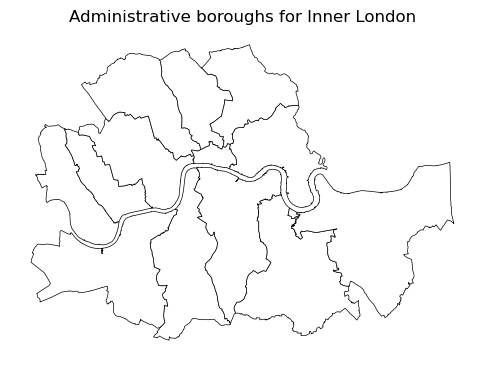

In [27]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
boroughs.plot(
    ax=ax, 
    linewidth=0.5,
    edgecolor='k', 
    facecolor='white'
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Administrative boroughs for Inner London');

为了更容易比较行政和 "区域化 "的边界线，我们可以将它们重叠起来。

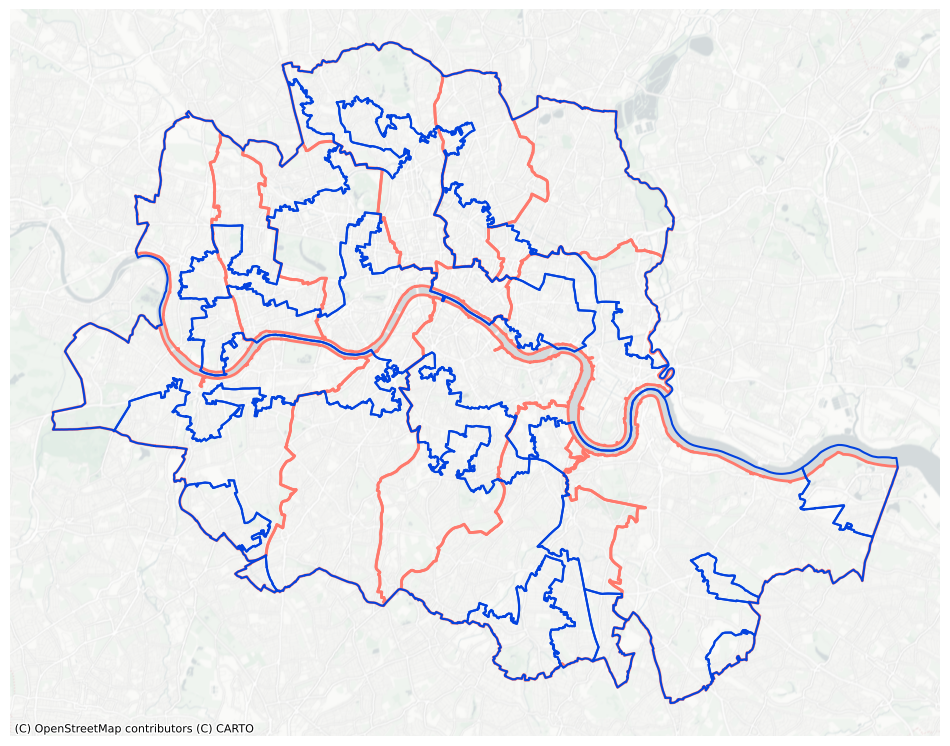

In [28]:
# Set up figure
f, ax = plt.subplots(1, figsize=(12, 12))
f.set_facecolor("w")

# Add boroughs
boroughs.to_crs(
    epsg=22770
).plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:salmon",
    linewidth=2
)

# Add regionalisation geography
abb_boroughs.to_crs(
    epsg=22770
).plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:blue",
    linewidth=1.5
)

# Add basemap
cx.add_basemap(
    ax,
    crs="EPSG:22770",
    source=cx.providers.CartoDB.PositronNoLabels
)

# Remove axis
ax.set_axis_off()
# Display clean
plt.show()

观察该图，两张地图之间有几个区别。最明显的一点是，虽然行政边界的大小非常平衡（伦敦市除外），但用空间聚类算法创建的区域在彼此之间的大小上有很大的不同。这是由基础数据的性质和算法本身造成的。从实质上讲，这表明基于AirBnb，我们可以观察到大面积的区域是相似的，因此被归入同一区域，同时也存在特征不同的小块区域，足以被归入不同区域。